# Project 1

## Question 1: Understanding the Dataset

> Overview: How many rows (samples) and columns (features) are present in the dataset?

Number of samples: 3476

Number of features: 8


In [2]:
import pandas as pd
import numpy as np

# load the dataset!
df = pd.read_csv('Project1-ClassificationDataset.csv')

# panda's shape returns a tuple (rows, cols)
rows = df.shape[0]
cols = df.shape[1]

print(f"\nNumber of samples: {rows}")
print(f"\nNumber of features: {cols}")

df.head()



Number of samples: 3476

Number of features: 8


,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,'Personalize Your NBA App Experience for the '...,'Personalize Your NBA App Experience for the '...,"['original', 'content', 'live', 'slate', 'game...",NaN,['Official Release'],https://www.nba.com/news/nba-app-new-features-...,basketball,sports
1,'Mike Will attends the Pre-GRAMMY Gala and GRA...,'Mike WiLL Made-It has secured a partnership w...,"['lead', 'espn', 'nbas', 'madeit', 'nba', 'lat...",2023-10-18 16:22:29+00:00,['Marc Griffin'],https://www.vibe.com/news/entertainment/mike-w...,basketball,sports
2,'The Golden State Warriors are struggling to f...,'The Golden State Warriors are struggling to f...,"['insider', 'york', 'thing', 'nbc', 'tag', 'nb...",NaN,[],https://www.nbcnewyork.com/tag/featured-nba/,basketball,sports
3,"'On Nov. 28, the NBA and Nike will collaborate...","'On Nov. 28, the NBA and Nike will collaborate...","['watch', 'telecast', 'ultimate', 'membership'...",NaN,['Official Release'],https://www.nba.com/news/watch-nba-games-ultim...,basketball,sports
4,'The NBA announced additions and innovations t...,'The NBA announced additions and innovations t...,"['experience', 'bring', 'media', 'crennan', 'n...",2023-10-17 12:00:17+00:00,"['Chris Novak', 'About Chris Novak']",https://awfulannouncing.com/tech/nba-app-2023-...,basketball,sports


Histograms: Plot 3 histograms: 


> (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis;



> (b) The column leaf label – class on the x-axis; 


> (c) The column root label – class on the x-axis

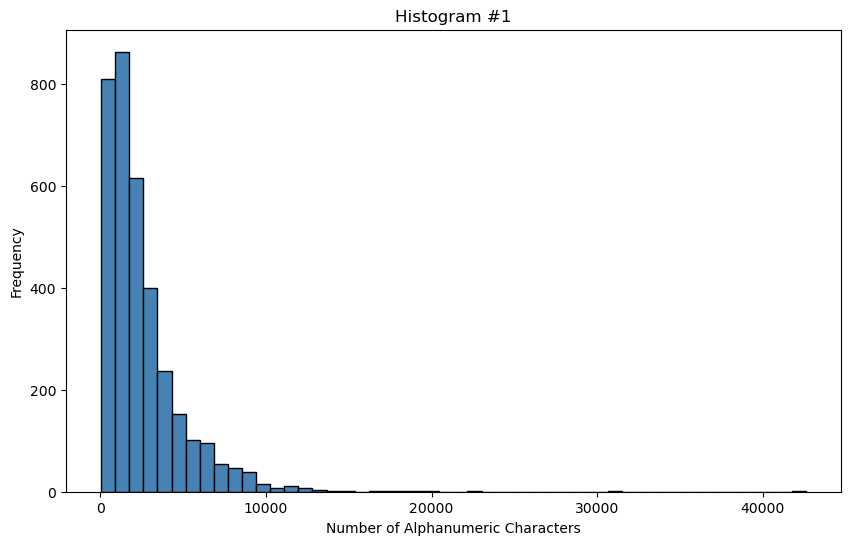

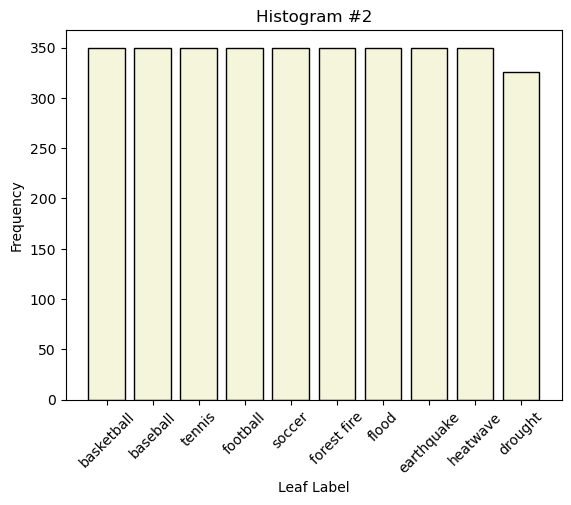

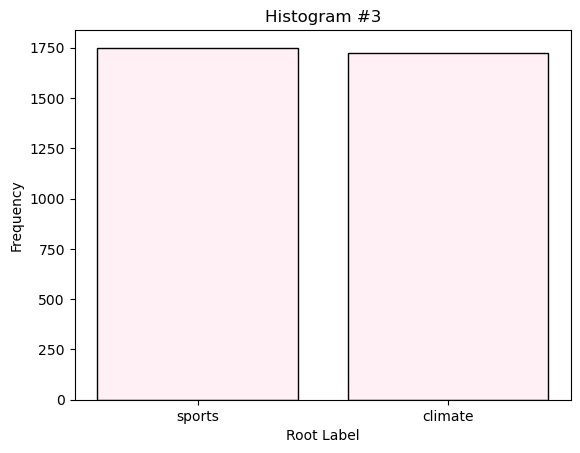

In [3]:
import matplotlib.pyplot as plt
import re

# (a)
df['alpha_num_char_count'] = df['full_text'].apply(lambda x: len(re.findall(r'\w', str(x)))) # count alphanumeric chars per row (A-Z, a-z) or (0-9) in full_text col

plt.figure(figsize=(10, 6))
plt.hist(df['alpha_num_char_count'], bins=50, color='steelblue', edgecolor='black')
plt.title('Histogram #1')
plt.xlabel('Number of Alphanumeric Characters')
plt.ylabel('Frequency')
plt.show()

# (b)
leaf_label_counts = df['leaf_label'].value_counts() # count leaf labels

plt.bar(leaf_label_counts.index, leaf_label_counts.values, color='beige', edgecolor='black')
plt.title('Histogram #2')
plt.xlabel('Leaf Label')
plt.ylabel('Frequency')
plt.xticks(rotation = 45)
plt.show()

# (c)
root_label_counts = df['root_label'].value_counts()

plt.bar(root_label_counts.index, root_label_counts.values, color='lavenderblush', edgecolor='black')
plt.title('Histogram #3')
plt.xlabel('Root Label')
plt.ylabel('Frequency')
plt.show()



> Interpret Plots: Provide qualitative interpretations of the histograms.


(a) The histogram is skewed to the left, with almost all rows containing 0-10k alphanumeric characters. This means that most news articles are pretty short. 


(b) The histogram is evenly distributed, with almost all leaf labels having freq of around 350 except for drought which has around 325. This means that the dataset has the same amount of news articles in each of their categories.


(c) The histogram is evenly distributed, with both sports and climate labels having a freq of around 1750. This means that news articles are also even in their broader categories, which is ideal because we don't have to worry about over and undersampling / imbalances!

## Question 2: Report the number of training and testing samples.

In [4]:
import numpy as np
import random
from sklearn.model_selection import train_test_split

np.random.seed(42)
random.seed(42)

df = pd.read_csv('Project1-ClassificationDataset.csv')
train, test = train_test_split(df[['full_text', 'root_label']], test_size=0.2)

print(f"Number of training samples: {len(train)}")
print(f"Number of testing samples: {len(test)}")

Number of training samples: 2780
Number of testing samples: 696


## Question 3: Use the following specs to extract features from the textual data

In [5]:
import re
from sklearn.feature_extraction.text import CountVectorizer

# Clean train and test sets
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub(r'\b-?\d+(\.\d+)?\b', '', texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter



In [6]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

import nltk

nltk.download('punkt_tab')  # Tokenizer
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')  # Lemmatizer

# lemmatize train and test sets
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()

    def penn2morphy(penntag):
        """ Converts Penn Treebank tags to WordNet. """
        morphy_tag = {'NN':'n', 'JJ':'a',
                    'VB':'v', 'RB':'r'}
        try:
            return morphy_tag[penntag[:2]]
        except:
            return 'n'
        
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(tokens)]
    return ' '.join(lemmatized)

train = train.map(clean).map(lemmatize)
test = test.map(clean).map(lemmatize)


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/abhim21/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/abhim21/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/abhim21/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
train
test

,full_text,root_label
2069,' a small patch of snow on the ground in douai...,climate
1425,"'antonio zago , of brazil , put on a jersey du...",sport
309,'new york > > the la vega ace become the first...,sport
2270,'christian abraham/hearst connecticut medium o...,climate
3037,'the city of watertown be currently under a wa...,climate
...,...,...
547,"'jasper , tx ( ) today period of rain . low 39...",sport
776,'the atp final the final tennis championship o...,sport
2873,'boston the regulation direct how the state co...,climate
2236,'after week of infighting and turmoil that hav...,climate


In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', min_df=3)

X_train = vectorizer.fit_transform(train['full_text'])

X_test = vectorizer.transform(test['full_text'])

print("Vocabulary:", vectorizer.vocabulary_)

X_train

Vocabulary: {'day': 3046, 'aftershock': 357, 'economic': 3782, 'impact': 5929, 'million': 7716, 'goldensky': 5129, 'festival': 4488, 'set': 10766, 'estimated': 4120, 'example': 4191, 'video': 12898, 'title': 12180, 'sacramento': 10428, 'calif': 1762, 'second': 10661, 'year': 13413, 'country': 2776, 'music': 7983, 'book': 1417, 'thousand': 12104, 'fan': 4368, 'discovery': 3437, 'park': 8738, 'organizer': 8522, 'look': 7137, 'expand': 4236, 'event': 4163, 'far': 4379, 'come': 2393, 'party': 8767, 'weekend': 13124, 'magical': 7265, 'say': 10539, 'chief': 2118, 'marketing': 7406, 'officer': 8401, 'danny': 3009, 'wimmer': 13233, 'present': 9322, 'growth': 5274, 'really': 9775, 'remarkable': 9992, 'heel': 5548, 'bring': 1559, 'region': 9912, 'wonderful': 13294, 'phenomenal': 8960, 'mike': 7697, 'ceo': 1996, 'visit': 12948, 'plan': 9061, 'underway': 12574, 'lot': 7160, 'folk': 4675, 'market': 7403, 'visitor': 12949, 'certainly': 2002, 'local': 7090, 'enjoy': 3993, 'people': 8880, 'outside': 8

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 417884 stored elements and shape (2780, 13485)>

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()

X_train = transformer.fit_transform(X_train)

X_test = transformer.transform(X_test)



> (a) What are the pros and cons of lemmatization versus stemming? How do these processes affect
the dictionary size?

Lemmatization reduces words to their lemma, and considers the word's part of speech (verb, vowel, etc), whereas stemming just strips suffixes from words to reduce them to the word's root. Lemmatization provides valid dictionary words (i.e meaningful words) and takes into account the POS. In contrast, stemming can frequently produce words that aren't in any dictionary. However, lemmatization is slower than stemming as it requires more computational power. Stemming much more drastically reduces the dictionary size than lemmatization, as words are reduced to their stem regardless of context. However, stemming can also create nonsense words, which can increase the dictionary size.

> (b) min df means minimum document frequency. How does varying min df change the TF-IDF
matrix?


If you increase min_df, it makes the TF-IDF matrix smaller, which leads to only frequently used terms. If you decrease min_df, it makes the TF-IDF matrix larger, which leads to a variety of terms including ones that aren’t used as frequently. This affects the efficiency and computational cost, as well as the vocabulary size.


> (c) Should I remove stopwords before or after lemmatizing? Should I remove punctuations before
or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall
that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position
of every word based on the sentence structure.

Generally, it’s better to remove as many unnecessary parts as you can, so you can have a smaller input size -> faster processing. 


It’s better to remove stopwords (“the”, “is”, etc) before lemmatizing because they don’t contribute to the actual meaning of the sentences. 


It’s better to remove punctuation marks before lemmatizing because it can lead to incorrect results when you tokenize. 


It’s better to remove numbers before lemmatizing because, like stopwords, do not contribute to the meaning of sentences. 


> (d) Report the shape of the TF-IDF-processed train and test matrices. The number of rows should
match the results of Question 2. The number of columns should roughly be in the order of
k ×103. This dimension will vary depending on your exact method of cleaning and lemmatizing
and that is okay.

## Question 4: Reduce the dimensionality of the data using the methods above

> (a) Plot the explained variance ratio across multiple different k = [1, 5, 10, 25, 50, 100, 500, 1000]
for LSI and for the next few sections choose k = 25. What does the explained variance ratio
plot look like? What does the plot’s concavity suggest?

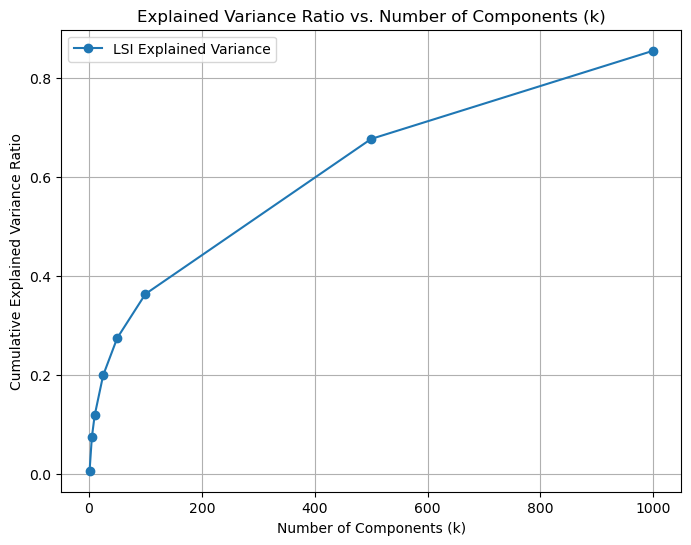

In [11]:
from sklearn.decomposition import TruncatedSVD

k_vals = [1, 5, 10, 25, 50, 100, 500, 1000]
explained_variance_ratios = []

for k in k_vals:
    svd = TruncatedSVD(n_components=k)
    svd.fit(X_train)
    explained_variance_ratios.append(np.sum(svd.explained_variance_ratio_))

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(k_vals, explained_variance_ratios, marker='o', label='LSI Explained Variance')
plt.title("Explained Variance Ratio vs. Number of Components (k)")
plt.xlabel("Number of Components (k)")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.grid(True)
plt.legend()
plt.show()

> (b) With k = 25 found in the previous sections, calculate the reconstruction residual MSE error when using LSI and NMF – they both should use the same k = 25. Which one is larger?

In [15]:
from sklearn.decomposition import NMF

# LSI Reconstruction
k = 25
svd = TruncatedSVD(n_components=k)
X_lsi = svd.fit_transform(X_train)
X_lsi_reconstructed = svd.inverse_transform(X_lsi)
lsi_residual_mse = np.linalg.norm(X_train - X_lsi_reconstructed, ord='fro')**2 / np.prod(X_train.shape)

# NMF Reconstruction
nmf = NMF(n_components=k, init='random', random_state=0, max_iter=500)
W = nmf.fit_transform(X_train)
H = nmf.components_
X_nmf_reconstructed = W @ H
nmf_residual_mse = np.linalg.norm(X_train - X_nmf_reconstructed, ord='fro')**2 / np.prod(X_train.shape)

print(f"LSI Reconstruction Residual MSE: {lsi_residual_mse}")
print(f"NMF Reconstruction Residual MSE: {nmf_residual_mse}")

LSI Reconstruction Residual MSE: 5.7478985807702994e-05
NMF Reconstruction Residual MSE: 5.789431549011321e-05


In [16]:
# Lets use LSI

X_train_reduced = svd.fit_transform(X_train)
X_test_reduced = svd.transform(X_test)

X_train_reduced
X_test_reduced

array([[ 0.19421513, -0.04369993, -0.0828814 , ..., -0.00158912,
        -0.01565262,  0.00499796],
       [ 0.14516483, -0.08660146,  0.06234547, ..., -0.05405986,
         0.04503732,  0.04429239],
       [ 0.18582718, -0.15846623,  0.16137809, ..., -0.00170668,
        -0.00958599, -0.06159441],
       ...,
       [ 0.18610643, -0.06092672, -0.20161912, ..., -0.07838355,
        -0.13926724,  0.03100072],
       [ 0.15483516, -0.0579328 , -0.05126756, ...,  0.0023188 ,
         0.02736086, -0.0062677 ],
       [ 0.11522629, -0.02056246, -0.04399784, ...,  0.00199766,
         0.00098992, -0.0011468 ]])

## Question 5: Compare and contrast hard-margin and soft-margin linear SVMs:

Train two linear SVMs:
> (a) Train one SVM with γ = 2000 (hard margin), another with γ = 0.0005 (soft margin).


> (b) Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set. Which one performs better? What about for γ = 100000?


> (c) What happens for the soft margin SVM? Why is the case? Analyze in terms of the
confusion matrix.


> (d) Does the ROC curve reflect the performance of the soft-margin SVM? Why?

In [17]:
from sklearn.svm import SVC

hard_margin = 2000
soft_margin = .0005

train_labels = train['root_label']
test_labels = test['root_label']

svm_hard_margin = SVC(kernel='linear', C=hard_margin)
svm_hard_margin.fit(X_train_reduced, train_labels)

svm_soft_margin = SVC(kernel='linear', C=soft_margin)
svm_soft_margin.fit(X_train_reduced, train_labels)

hard_predictions = svm_hard_margin.predict(X_test_reduced)
soft_predictions = svm_soft_margin.predict(X_test_reduced)

hard_predictions
soft_predictions



array(['climate', 'climate', 'climate', 'climate', 'climate', 'climate',
       'climate', 'climate', 'climate', 'climate', 'climate', 'climate',
       'climate', 'climate', 'climate', 'climate', 'climate', 'climate',
       'climate', 'climate', 'climate', 'climate', 'climate', 'climate',
       'climate', 'climate', 'climate', 'climate', 'climate', 'climate',
       'climate', 'climate', 'climate', 'climate', 'climate', 'climate',
       'climate', 'climate', 'climate', 'climate', 'climate', 'climate',
       'climate', 'climate', 'climate', 'climate', 'climate', 'climate',
       'climate', 'climate', 'climate', 'climate', 'climate', 'climate',
       'climate', 'climate', 'climate', 'climate', 'climate', 'climate',
       'climate', 'climate', 'climate', 'climate', 'climate', 'climate',
       'climate', 'climate', 'climate', 'climate', 'climate', 'climate',
       'climate', 'climate', 'climate', 'climate', 'climate', 'climate',
       'climate', 'climate', 'climate', 'climate', 

In [18]:
svm_1000 = SVC(kernel='linear', C=1000)
svm_1000.fit(X_train_reduced, train_labels)

svm_1000_predictions = svm_1000.predict(X_test_reduced)

svm_1000_predictions

array(['climate', 'sport', 'sport', 'climate', 'climate', 'sport',
       'sport', 'climate', 'climate', 'climate', 'climate', 'climate',
       'climate', 'sport', 'sport', 'sport', 'sport', 'sport', 'sport',
       'sport', 'climate', 'sport', 'sport', 'sport', 'sport', 'sport',
       'climate', 'climate', 'sport', 'sport', 'sport', 'sport', 'sport',
       'climate', 'climate', 'sport', 'sport', 'climate', 'sport',
       'sport', 'climate', 'climate', 'sport', 'sport', 'sport', 'sport',
       'sport', 'sport', 'climate', 'climate', 'sport', 'climate',
       'sport', 'climate', 'sport', 'sport', 'climate', 'climate',
       'sport', 'climate', 'sport', 'climate', 'sport', 'sport', 'sport',
       'sport', 'climate', 'climate', 'climate', 'climate', 'climate',
       'sport', 'climate', 'climate', 'climate', 'climate', 'climate',
       'climate', 'sport', 'climate', 'climate', 'climate', 'sport',
       'climate', 'sport', 'climate', 'climate', 'sport', 'sport',
       'climate',

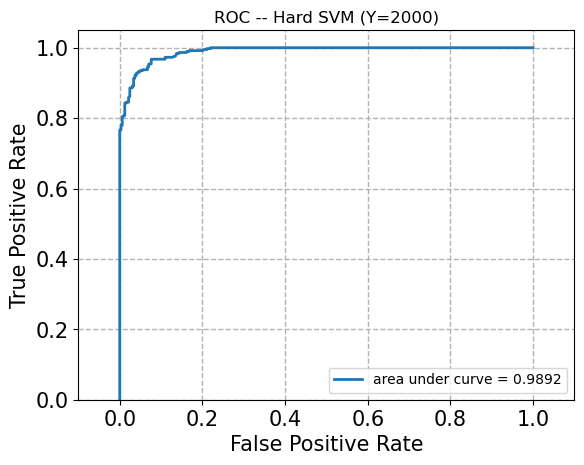

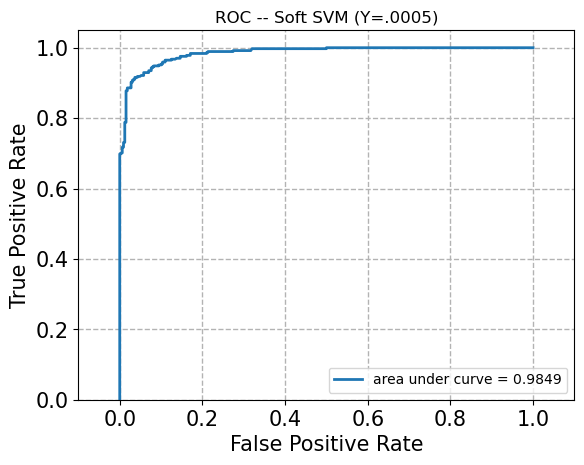

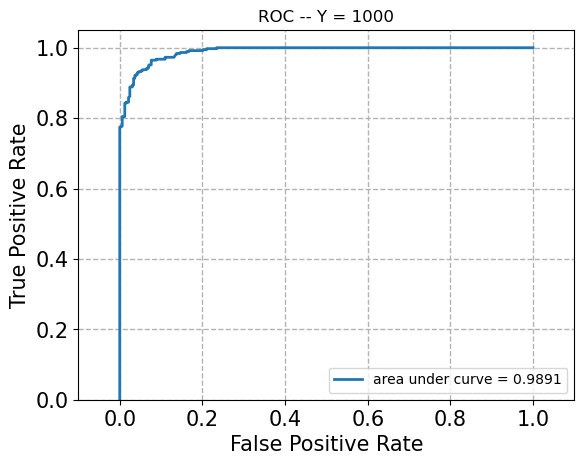

In [19]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

def plot_roc(fpr, tpr, title):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)
    ax.set_title(title)
    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

fpr_hard, tpr_hard, thresholds = roc_curve(test_labels, svm_hard_margin.decision_function(X_test_reduced), pos_label='sport')
fpr_soft, tpr_soft, thresholds = roc_curve(test_labels, svm_soft_margin.decision_function(X_test_reduced), pos_label='sport')
fpr_1000, tpr_1000, thresholds = roc_curve(test_labels, svm_1000.decision_function(X_test_reduced), pos_label='sport')

plot_roc(fpr_hard, tpr_hard, title="ROC -- Hard SVM (Y=2000)")
plot_roc(fpr_soft, tpr_soft, title="ROC -- Soft SVM (Y=.0005)")
plot_roc(fpr_1000, tpr_1000, title="ROC -- Y = 1000")


Text(0.5, 1.0, 'Confusion Matrix - Y = 1000')

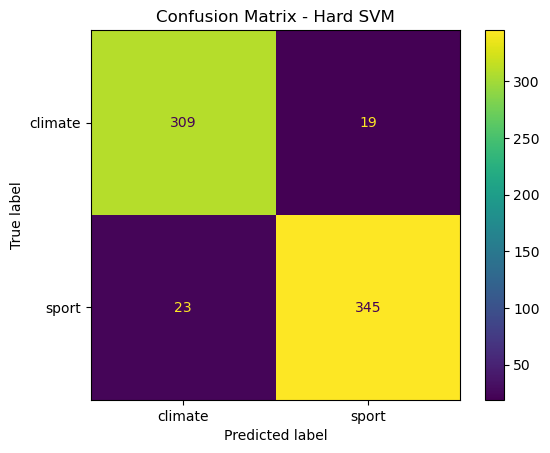

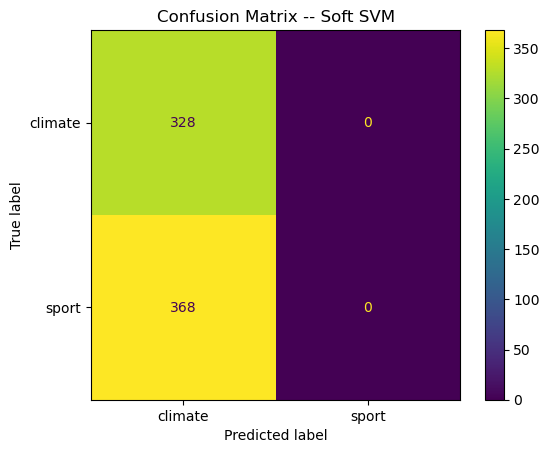

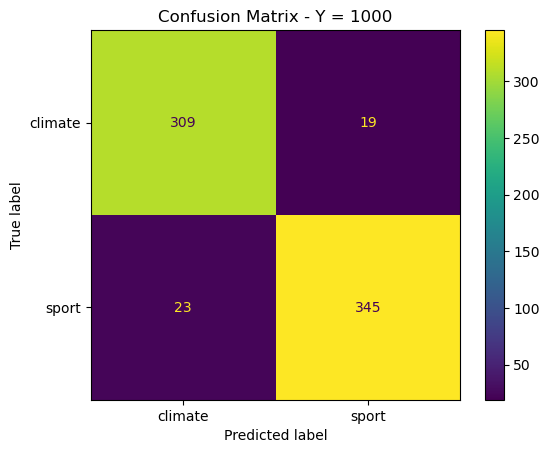

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(svm_hard_margin, X_test_reduced, test_labels)
plt.title("Confusion Matrix - Hard SVM")

ConfusionMatrixDisplay.from_estimator(svm_soft_margin, X_test_reduced, test_labels)
plt.title("Confusion Matrix -- Soft SVM")

ConfusionMatrixDisplay.from_estimator(svm_1000, X_test_reduced, test_labels)
plt.title("Confusion Matrix - Y = 1000")

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_perf_params(test_labels, predictions):
    acc = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions, pos_label='sport')
    recall = recall_score(test_labels, predictions, pos_label='sport')
    f1 = f1_score(test_labels, predictions, pos_label='sport')

    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

print("Hard Margin SVM Performance Metrics")
print_perf_params(test_labels, hard_predictions)

print("\nSoft Margin SVM Performance Metrics")
print_perf_params(test_labels, soft_predictions)

print("\nY = 1000 Performance Metrics")
print_perf_params(test_labels, svm_1000_predictions)

    

Hard Margin SVM Performance Metrics
Accuracy: 0.9396551724137931
Precision: 0.9478021978021978
Recall: 0.9375
F1 Score: 0.9426229508196722

Soft Margin SVM Performance Metrics
Accuracy: 0.47126436781609193
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Y = 1000 Performance Metrics
Accuracy: 0.9396551724137931
Precision: 0.9478021978021978
Recall: 0.9375
F1 Score: 0.9426229508196722


/opt/anaconda3/envs/proj1_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Use cross-validation to choose γ (use average validation 3 accuracy to compare): Using a 5-fold cross-validation, find the best value of the parameter γ in the range {10k| − 3 ≤ k ≤ 6, k ∈ Z}. Again, plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this best SVM

{0.001: 0.5028776978417266, 0.01: 0.7827338129496402, 0.1: 0.9284172661870503, 1.0: 0.9381294964028777, 10.0: 0.9446043165467625, 100.0: 0.9492805755395685, 1000.0: 0.9489208633093525, 10000.0: 0.9503597122302159, 100000.0: 0.9503597122302159, 1000000.0: 0.9503597122302159}
Best Gamma: 10000.0
Accuracy: 0.9396551724137931
Precision: 0.9478021978021978
Recall: 0.9375
F1 Score: 0.9426229508196722


Text(0.5, 1.0, 'Confusion Matrix -- Best Gamma (y=10000.0)')

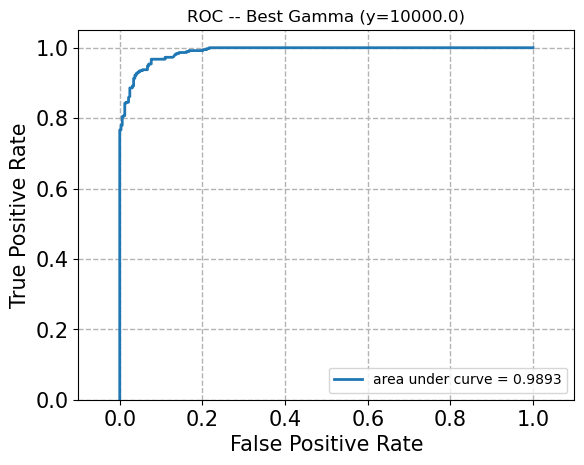

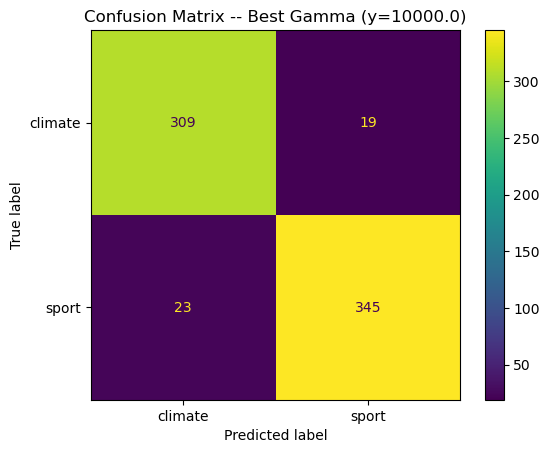

In [27]:
from sklearn.model_selection import cross_val_score

gamma_values = np.logspace(-3, 6, 10)

avg_accuracies = {}

for gamma in gamma_values:
    svm = SVC(kernel='linear', C=gamma)
    accuracies = cross_val_score(svm, X_train_reduced, train_labels, cv=5)
    avg_accuracies[gamma] = np.mean(accuracies)

print(avg_accuracies)

best_gamma = max(avg_accuracies, key=avg_accuracies.get)

print(f"Best Gamma: {best_gamma}")

svm_best_gamma = SVC(kernel='linear', C=best_gamma)
svm_best_gamma.fit(X_train_reduced, train_labels)

predictions_best_gamma = svm_best_gamma.predict(X_test_reduced)

fpr_best_gamma, tpr_best_gamma, thresholds = roc_curve(test_labels, svm_best_gamma.decision_function(X_test_reduced), pos_label='sport')

plot_roc(fpr_best_gamma, tpr_best_gamma, title=f"ROC -- Best Gamma (y={best_gamma})")

print_perf_params(test_labels, predictions_best_gamma)

ConfusionMatrixDisplay.from_estimator(svm_best_gamma, X_test_reduced, test_labels)
plt.title(f"Confusion Matrix -- Best Gamma (y={best_gamma})")





## Question 6: Evaluate a logistic classifier

Train a logistic classifier without regularization (you may need to come up with some way to
approximate this if you use sklearn.linear model.LogisticRegression); plot the ROC
curve and report the confusion matrix and calculate the accuracy, recall precision and F-1
score of this classifier on the testing set

Logistic Regression Performance Metrics
Accuracy: 0.9396551724137931
Precision: 0.9429347826086957
Recall: 0.9429347826086957
F1 Score: 0.9429347826086957


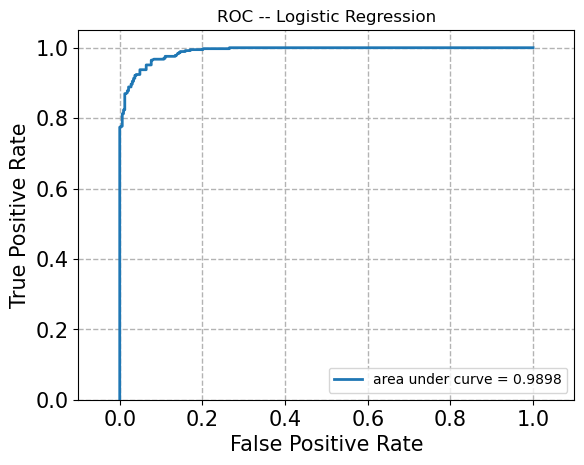

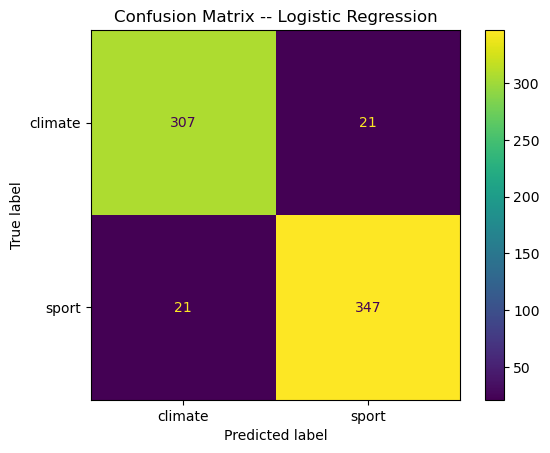

In [30]:
from sklearn.linear_model import LogisticRegression

log_clf_no_reg = LogisticRegression(penalty=None)

log_clf_no_reg.fit(X_train_reduced, train_labels)

log_predictions = log_clf_no_reg.predict(X_test_reduced)

fpr_log, tpr_log, thresholds = roc_curve(test_labels, log_clf_no_reg.decision_function(X_test_reduced), pos_label='sport')

plot_roc(fpr_log, tpr_log, title="ROC -- Logistic Regression")

ConfusionMatrixDisplay.from_estimator(log_clf_no_reg, X_test_reduced, test_labels)
plt.title("Confusion Matrix -- Logistic Regression")

print("Logistic Regression Performance Metrics")
print_perf_params(test_labels, log_predictions)


Find the optimal regularization coefficient:


> (a) Using 5-fold cross-validation on the dimension-reduced-by-SVD training data, find the optimal regularization strength in the range {10k|−5 ≤ k ≤ 5, k ∈ Z} for logistic regression with L1 regularization and logistic regression with L2 regularization, respectively.


> (b) Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.


> (c) How does the regularization parameter affect the test error? How are the learnt coefficients affected? Why might one be interested in each type of regularization?


> (d) Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. What is the difference between their ways to find this boundary? Why do their performances differ? Is this difference statistically significant?

In [43]:
from sklearn.model_selection import GridSearchCV

reg_strengths = np.logspace(-5, 5, 11)

param_grid = {'C': reg_strengths}

log_clf_l1 = LogisticRegression(penalty='l1', solver='liblinear')
log_clf_l2 = LogisticRegression(penalty='l2')

grid_search_l1 = GridSearchCV(log_clf_l1, param_grid, cv=5)
grid_search_l2 = GridSearchCV(log_clf_l2, param_grid, cv=5)

grid_search_l1.fit(X_train_reduced, train_labels)
grid_search_l2.fit(X_train_reduced, train_labels)

best_l1_strength = grid_search_l1.best_params_['C']
best_l2_strength = grid_search_l2.best_params_['C']

print(f"Best L1 Regularization Strength: {best_l1_strength}")
print(f"Best L2 Regularization Strength: {best_l2_strength}")


Best L1 Regularization Strength: 100.0
Best L2 Regularization Strength: 1000.0


In [45]:
log_clf_l1 = LogisticRegression(penalty='l1', C=best_l1_strength, solver='liblinear')
log_clf_l2 = LogisticRegression(penalty='l2', C=best_l2_strength)

log_clf_l1.fit(X_train_reduced, train_labels)
log_clf_l2.fit(X_train_reduced, train_labels)

log_predictions_l1 = log_clf_l1.predict(X_test_reduced)
log_predictions_l2 = log_clf_l2.predict(X_test_reduced)

print("L1 Regularization Performance Metrics")
print_perf_params(test_labels, log_predictions_l1)

print("\nL2 Regularization Performance Metrics")
print_perf_params(test_labels, log_predictions_l2)

print("\nNo Regularization Performance Metrics")
print_perf_params(test_labels, log_predictions)

L1 Regularization Performance Metrics
Accuracy: 0.9396551724137931
Precision: 0.9429347826086957
Recall: 0.9429347826086957
F1 Score: 0.9429347826086957

L2 Regularization Performance Metrics
Accuracy: 0.9410919540229885
Precision: 0.943089430894309
Recall: 0.9456521739130435
F1 Score: 0.9443690637720489

No Regularization Performance Metrics
Accuracy: 0.9396551724137931
Precision: 0.9429347826086957
Recall: 0.9429347826086957
F1 Score: 0.9429347826086957


## Question 7: Evaluate and profile a Na ̈ıve Bayes classifier
Train a GaussianNB classifier.


Plot the ROC curve and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of this classifier on the testing set.

Gaussian Naive Bayes Performance Metrics
Accuracy: 0.9080459770114943
Precision: 0.8707317073170732
Recall: 0.970108695652174
F1 Score: 0.9177377892030848


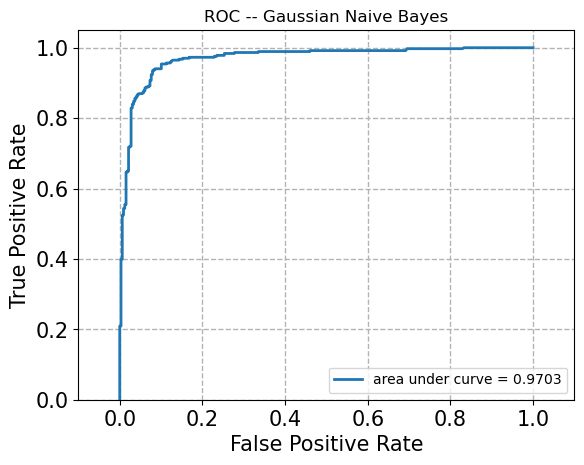

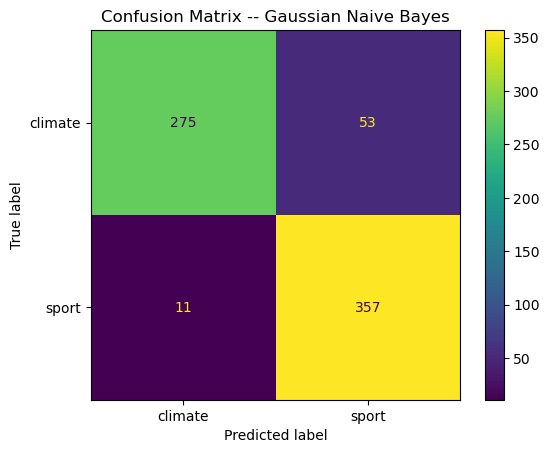

In [46]:
from sklearn.naive_bayes import GaussianNB

gnb_clf = GaussianNB()
gnb_clf.fit(X_train_reduced, train_labels)

gnb_predictions = gnb_clf.predict(X_test_reduced)

fpr_gnb, tpr_gnb, thresholds = roc_curve(test_labels, gnb_clf.predict_proba(X_test_reduced)[:,1], pos_label='sport')

plot_roc(fpr_gnb, tpr_gnb, title="ROC -- Gaussian Naive Bayes")

ConfusionMatrixDisplay.from_estimator(gnb_clf, X_test_reduced, test_labels)
plt.title("Confusion Matrix -- Gaussian Naive Bayes")

print("Gaussian Naive Bayes Performance Metrics")
print_perf_params(test_labels, gnb_predictions)

## Question 8: In this part, you will attempt to find the best model for binary classification.

> Construct a Pipeline that performs feature extraction, dimensionality reduction and classifi-
cation;

In [49]:
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp
from joblib import Memory
from nltk.stem import PorterStemmer

cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=10)

# Preprocessing functions
def preprocess_text(data, method='lemmatization', min_df=2):
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    
    if method == 'lemmatization':
        processed = [' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(doc)]) for doc in data]
    elif method == 'stemming':
        processed = [' '.join([stemmer.stem(word) for word in word_tokenize(doc)]) for doc in data]
    else:
        processed = data
    
    # Apply CountVectorizer with specified min_df
    vectorizer = CountVectorizer(min_df=min_df)
    features = vectorizer.fit_transform(processed)
    tfidf_features = TfidfTransformer().fit_transform(features)
    return tfidf_features

datasets = {
    'lemmatization_min_df_2': preprocess_text(train['full_text'], method='lemmatization', min_df=2),
    'lemmatization_min_df_5': preprocess_text(train['full_text'], method='lemmatization', min_df=5),
    'stemming_min_df_2': preprocess_text(train['full_text'], method='stemming', min_df=2),
    'stemming_min_df_5': preprocess_text(train['full_text'], method='stemming', min_df=5)
}


pipeline = Pipeline([
    ('reduce_dim', TruncatedSVD(random_state=0)),  
    ('clf', GaussianNB())
], memory=memory)

N_COMPONENTS = [5, 30, 100]

param_grid = {
    'reduce_dim': [TruncatedSVD(n_components=k) for k in N_COMPONENTS] + 
    [NMF(n_components=k) for k in N_COMPONENTS],
    'clf': [SVC(kernel='linear', C=best_gamma), LogisticRegression(penalty='l1', C=best_l1_strength, solver='liblinear'),
            LogisticRegression(penalty='l2', C=best_l2_strength), GaussianNB()]
}

results = {}

for key, dataset in datasets.items():
    print(f"Processing dataset: {key}")
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=1)
    grid_search.fit(dataset.toarray(), train_labels)  # Replace labels with actual ones
    results[key] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

# Display results
for key, result in results.items():
    print(f"Dataset: {key}")
    print("Best Parameters:", result['best_params'])
    print("Best Cross-Validation Score:", result['best_score'])
    print()



Processing dataset: lemmatization_min_df_2
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=5), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), 560       sport
707       sport
424       sport
1093      sport
647       sport
         ...   
1095      sport
1130      sport
1294      sport
860       sport
3174    climate
Name: root_label, Length: 2224, dtype: object, 
None, message_clsname='Pipeline', message=None, params={ 'decision_function': {},
  'fit': {},
  'fit_predict': {},
  'fit_transform': {},
  'inverse_transform': {},
  'partial_fit': {},
  'predict': {},
  'predict_log_proba': {},
  'predict_proba': {},
  'score': {},
  'split': {},
  'transform': {}})
________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklear

/opt/anaconda3/envs/proj1_env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


_______________________________________________fit_transform_one - 85.5s, 1.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=100), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), 2677    climate
1204      sport
2955    climate
2266    climate
611       sport
         ...   
1095      sport
1130      sport
1294      sport
860       sport
3174    climate
Name: root_label, Length: 2224, dtype: object, 
None, message_clsname='Pipeline', message=None, params={ 'decision_function': {},
  'fit': {},
  'fit_predict': {},
  'fit_transform': {},
  'inverse_transform': {},
  'partial_fit': {},
  'predict': {},
  'predict_log_proba': {},
  'predict_proba': {},
  'score': {},
  'split': {},
  'transform': {}})
_______________________________________________fit_transform_one - 73.7s, 1.2min
_________________________________________________________________________

> The evaluation of each combination is performed with 5-fold cross-validation (use the average
validation set accuracy across folds).

> In addition to any other hyperparameters you choose, your gridsearch must at least include:

> What are the 5 best combinations? Report their performances on the testing set.

## Question 9: In this part, we aim to learn classifiers on the documents belonging to unique classes in the column leaf label.


Perform Na ̈ıve Bayes classification and multiclass SVM classification (with both One VS One and One VS the rest methods described above) and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of your classifiers. How did you resolve the class imbalance issue in the One VS the rest model?

> In the confusion matrix you should have an 10 × 10 matrix where 10 is the number of unique
labels in the column leaf label. Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the major diagonal? What does this mean?

> Based on your observation from the previous part, suggest a subset of labels that should be
merged into a new larger label and recompute the accuracy and plot the confusion matrix.
How did the accuracy change in One VS One and One VS the rest?

> Does class imbalance impact the performance of the classification once some classes are
merged? Provide a resolution for the class imbalance and recompute the accuracy and plot
the confusion matrix in One VS One and One VS the rest?.

## Question 10: Read the paper about GLoVE embeddings and answer the following subquestions.

> (a) Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than
the probabilities themselves?


Glove embeddings are trained on the ratio of co-occurrence probabilities instead of the probabilities themselves because training on the co-occurrence probabilities better captures the semantic relationships between words. This is because words that occur together usually indicate relationships (like similarities or contrasts). 

> (b) In the two sentences: “James is running in the park.” and “James is running for the presidency.”, would GLoVE embeddings return the same vector for the word running in both cases? Why or why not?


Glove embeddings would return the same vector for both of those sentences because they’re context independent (it only learns relationships from the probabilities of the co-occurrences).

> (c) What do you expect for the values of,
||GLoVE["left"] - GLoVE["right"]||2, ||GLoVE["wife"] - GLoVE["husband"]||2 and ||GLoVE["wife"] - GLoVE["orange"]||2 ? Compare these values.


The expressions are euclidean distance equations. Left and right have an opposite relationship, but are used in the same context -> small distance. Wife and husband are also used in the same context -> small distance. Wife and orange are unrelated / don’t have a relationship -> large distance.

> (d) Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE embedding?


I'd rather lemmatize the word before mapping it to its glove embedding because it's more accurate and is less likely to produce an incorrect result. If it did produce an incorrect result (such as "running" -> "runn") then it wouldn't match a glove embedding. 



## Question 11: For the binary classification task distinguishing the “sports” class and “climate”class.

> (a) Describe a feature engineering process that uses GLoVE word embeddings to represent each
document.


> (b) Select a classifier model, train and evaluate it with your GLoVE-based feature. If you are doing
any cross-validation, please make sure to use a limited set of options so that your code finishes
running in a reasonable amount of time.

## Question 12: Plot the relationship between the dimension of the pre-trained GLoVE embedding and the resulting accuracy of the model in the classification task. 

Describe the observed trend. Is this trend expected? Why or why not? In this part use the different sets of GLoVE vectors from the
link.

## Question 13: Compare and contrast the two visualizations. 

Are there clusters formed in either or both of the plots? We will pursue the clustering aspect further in the next project. 